In [48]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import random

In [16]:
folder_path = "./data"

In [29]:
# Directory containing your Parquet files
relative_path_to_data = folder_path
data_directory = os.path.abspath(relative_path_to_data)

# Desired file stems to load
# desired_files = {
#     "df_edge_list_undirected_users_postings_replies",
#     "df_edge_list_directed_users_postings_replies",
# }

# Dictionary to store DataFrames with stem names as keys
dataframes = {}

# Iterate over all Parquet files in the directory
for file_path in Path(data_directory).glob("*.parquet"):

    # Extract the file stem (name without extension)
    file_stem = file_path.stem
    
    # Check if the file stem is in the desired list
    # if file_stem in desired_files:
    print(f"Reading file: {file_stem}")
        
        # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)
        
        # Store the DataFrame in the dictionary with the stem as the key
    dataframes[file_stem] = df
        
        # Optionally, break if all desired files are loaded
        # if len(dataframes) == len(desired_files):
        #     break

# Access DataFrames by their file stem
print(dataframes.keys())  # Prints the stems of all loaded files

Reading file: df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections
Reading file: df_edge_list_undirected_users_postings_to_same_articles
Reading file: df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net
Reading file: df_edge_list_undirected_users_postings_replies
Reading file: df_edge_list_directed_users_votes_to_postings_net
Reading file: df_edge_list_undirected_users_votes_to_postings_net
Reading file: df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net
Reading file: df_edge_list_undirected_users_click_similarity
Reading file: df_edge_list_undirected_users_votes_to_same_postings_net
Reading file: df_edge_list_directed_users_postings_replies
dict_keys(['df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections', 'df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_directed_users_combined_postings_replies_and_votes_

In [30]:
# Assign DataFrames to new variable names
undirected_replies = dataframes["df_edge_list_undirected_users_postings_replies"]
directed_replies = dataframes["df_edge_list_directed_users_postings_replies"]

undirected_votes = dataframes["df_edge_list_undirected_users_votes_to_postings_net"]
directed_votes = dataframes["df_edge_list_directed_users_votes_to_postings_net"]

combined_undirected = dataframes["df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net"]
combined_directed = dataframes["df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net"]

click_similarity = dataframes["df_edge_list_undirected_users_click_similarity"]
same_articles = dataframes["df_edge_list_undirected_users_postings_to_same_articles"]
votes_to_same_postings = dataframes["df_edge_list_undirected_users_votes_to_same_postings_net"]

follow_connections = dataframes["df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections"]

# Verify the updated key names in the dictionary
print("Updated DataFrame keys:", dataframes.keys())

# Example access
print(directed_votes.head())  # View the first few rows of one of the DataFrames

Updated DataFrame keys: dict_keys(['df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections', 'df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net', 'df_edge_list_undirected_users_postings_replies', 'df_edge_list_directed_users_votes_to_postings_net', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net', 'df_edge_list_undirected_users_click_similarity', 'df_edge_list_undirected_users_votes_to_same_postings_net', 'df_edge_list_directed_users_postings_replies'])
   ID_CommunityIdentity_Source  ID_CommunityIdentity_Target  \
0                            4                         6293   
1                            4                         8008   
2                            4                         9525   
3                            4                        18764   


In [31]:
print("Undirected Replies DataFrame Info:")
print(undirected_votes.info(), "\n")

print("Directed Replies DataFrame Info:")
print(directed_votes.info(), "\n")

Undirected Replies DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535637 entries, 0 to 5535636
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_min     int64
 1   ID_CommunityIdentity_max     int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 126.7 MB
None 

Directed Replies DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105250 entries, 0 to 6105249
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_Source  int64
 1   ID_CommunityIdentity_Target  int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 139.7 MB
None 



In [35]:
print("Missing Data in Undirected Replies:")
print(undirected_votes.isnull().sum(), "\n")

print("Missing Data in Directed Replies:")
print(directed_votes.isnull().sum(), "\n")

Missing Data in Undirected Replies:
ID_CommunityIdentity_min       0
ID_CommunityIdentity_max       0
count_votes_to_postings_net    0
dtype: int64 

Missing Data in Directed Replies:
ID_CommunityIdentity_Source    0
ID_CommunityIdentity_Target    0
count_votes_to_postings_net    0
dtype: int64 



### Link Prediction

In [37]:
# 1. Convert the directed votes dataset into a graph
G_directed = nx.from_pandas_edgelist(
    directed_votes,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_Source",
    target="ID_CommunityIdentity_Target",
    edge_attr="count_votes_to_postings_net",  # Optional: edge weights
    create_using=nx.DiGraph()  # Ensure a directed graph
)


In [38]:
G.is_directed()

True

In [39]:
# subgraph

# Sample a smaller subgraph
subgraph = G.subgraph(list(G.nodes)[:100])  # Adjust the size as needed


In [40]:
subgraph.number_of_nodes()

100

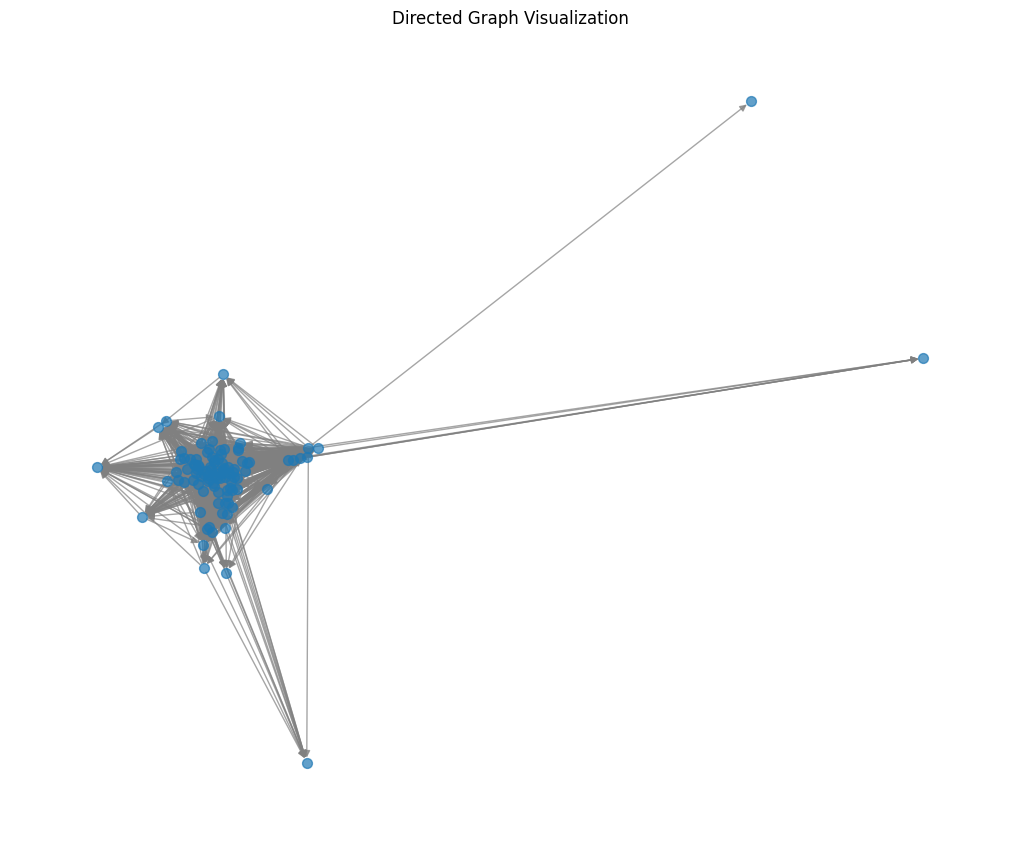

In [41]:
# Visualize the graph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)  # Compute the layout for node positioning
nx.draw(
    subgraph, 
    pos, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Directed Graph Visualization")
plt.show()

### Preprocessing and train test split

In [49]:
# Step 1: Extract edges
edges = list(G_directed.edges())

# Step 2: Train-test split
train_edges, test_edges = train_test_split(edges, test_size=0.3, random_state=42)

# Split train into training and validation
train_edges, val_edges = train_test_split(train_edges, test_size=0.1, random_state=42)

# Step 3: Generate negative edges (non-edges)
nodes = list(G_directed.nodes())
negative_edges = []
while len(negative_edges) < len(test_edges) + len(val_edges):
    u, v = random.sample(nodes, 2)
    if not G_directed.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
        negative_edges.append((u, v))

# Split negative edges into validation and test
val_edges_false = negative_edges[:len(val_edges)]
test_edges_false = negative_edges[len(val_edges):len(val_edges) + len(test_edges)]

# Step 4: Create the training graph
G_train = nx.DiGraph()
G_train.add_edges_from(train_edges)

# Print summary
print(f"Total nodes: {G_directed.number_of_nodes()}")
print(f"Total edges in original graph: {len(edges)}")
print(f"Training edges: {len(train_edges)}")
print(f"Validation edges (positive): {len(val_edges)}, Validation edges (negative): {len(val_edges_false)}")
print(f"Test edges (positive): {len(test_edges)}, Test edges (negative): {len(test_edges_false)}")

KeyboardInterrupt: 

### Train Node2vec

In [ ]:
# Step 1: Train Node2Vec on the training graph
node2vec = Node2Vec(
    G_train, 
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings
embeddings = {str(node): model.wv[str(node)] for node in G_train.nodes()}

# Step 2: Generate edge features
def edge_to_feature(edge):
    """Convert an edge to a feature vector by concatenating the embeddings of its nodes."""
    u, v = edge
    return embeddings[str(u)] + embeddings[str(v)]  # Element-wise addition

# Prepare training data
X_train = [edge_to_feature(edge) for edge in train_edges]
y_train = [1] * len(train_edges)  # Positive edges
X_train += [edge_to_feature(edge) for edge in train_edges_false]
y_train += [0] * len(train_edges_false)  # Negative edges

# Step 3: Train a classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Step 4: Evaluate the model
# Validation set
X_val = [edge_to_feature(edge) for edge in val_edges] + [edge_to_feature(edge) for edge in val_edges_false]
y_val = [1] * len(val_edges) + [0] * len(val_edges_false)

y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_proba))

# Test set
X_test = [edge_to_feature(edge) for edge in test_edges] + [edge_to_feature(edge) for edge in test_edges_false]
y_test = [1] * len(test_edges) + [0] * len(test_edges_false)

y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_proba))